In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

working_dir = "/epyc/projects/dschaub/method-projects/spatialnca"
import os

os.chdir(working_dir)
import scanpy as sc
import nichepca as npc
import torch_geometric as pyg
import numpy as np
import torch
import matplotlib.pyplot as plt

from types import SimpleNamespace

from spatialnca.preprocess import PreProcessor, adata_to_pyg
from spatialnca.model import SpatialNCA
from spatialnca.train import Trainer
from spatialnca.utils import seed_everything

## Load data

In [2]:
path = "data/Zhuang-ABCA-3.003_slice.h5ad"
adata = sc.read_h5ad(path)
adata

AnnData object with n_obs × n_vars = 318 × 1122
    obs: 'brain_section_label', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'abc_sample_id', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_index', 'parcellation_organ', 'parcellation_category', 'parcellation_division', 'parcellation_structure', 'parcellation_substructure', 'parcellation_organ_color', 'parcellation_category_color', 'parcellation_division_color', 'parcellation_structure_color', 'parcellation_substructure_color', 'domain', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster'
    var: 'gene_identifier'
    uns: 'parcellation_substructure_colors', 'subclass_colors'
    obsm: 'spatial'

In [3]:
cfg = SimpleNamespace()
# overall
cfg.seed = 42

# data
cfg.n_pcs = 50

# model
cfg.emb_dim = 32
cfg.knn = 10

# training
cfg_train = SimpleNamespace()
cfg_train.n_epochs = 10000
cfg_train.n_steps = 5
cfg_train.lr = 1e-3
cfg_train.clip_value = 1.0
cfg_train.device = "cuda"

  0%|          | 0/10000 [00:00<?, ?it/s]

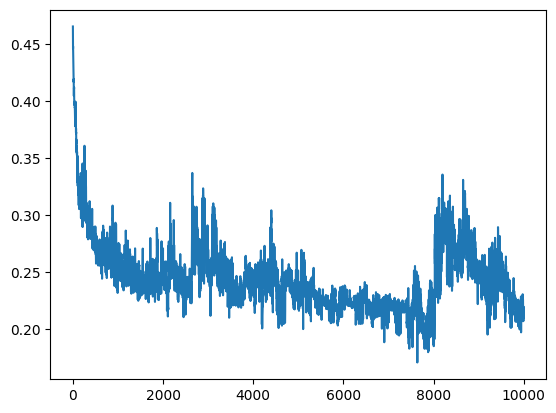

In [4]:
# seed everything
seed_everything(cfg.seed)

preprocessor = PreProcessor(cfg.n_pcs)
preprocessor.fit_transform(adata)
data = adata_to_pyg(adata)

spnca = SpatialNCA(data.num_features, emb_dim=cfg.emb_dim, knn=cfg.knn)

trainer = Trainer(model=spnca, **cfg_train.__dict__)

trainer.train(data)

trainer.plot_history()

In [5]:
data

Data(x=[318, 50], pos=[318, 2], pos_init=[318, 2])

In [6]:
# perform another rollout to check the result
h, pos, edge_index = spnca.rollout(
    x=data.x, pos=data.pos_init, n_steps=cfg_train.n_steps
)

# convert to anndata for plotting
ad_tmp = adata.copy()
ad_tmp.obsm["spatial"] = pos.cpu().detach().numpy()

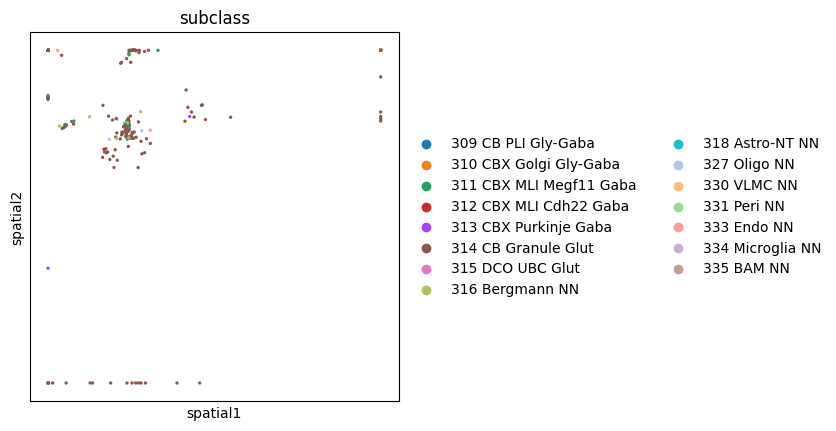

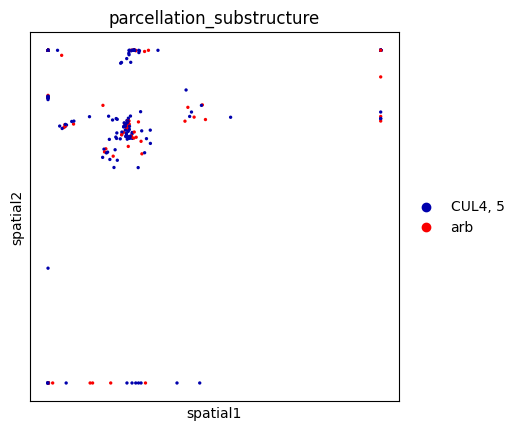

In [9]:
sc.pl.spatial(ad_tmp, color="subclass", spot_size=0.01)
plt.show()
sc.pl.spatial(ad_tmp, color="parcellation_substructure", spot_size=0.01)